In [1]:
%matplotlib inline

import requests
import pandas as pd
from crossref.restful import Works, Etiquette, Journals
import json
import shapely
import re
import geopandas as gpd
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm.contrib.concurrent import thread_map
import itertools
import numpy as np
import spacy
import pycountry
import orcid

nlp = spacy.load('en_core_web_sm')

## 1. Load files

### 1.1 Specimen/location data

Load a list of specimens from PetDB.

In [2]:
specimens_df = pd.read_csv('PetDB_specimen_summary.csv', usecols=['specimen_num', 'geometry_text', 'citation_nums'], index_col='specimen_num')

# convert citation_nums to lists
rgx = re.compile('\d+')

def convert_citation(x):
    if isinstance(x, str):
        return list(set([int(i) for i in rgx.findall(x)]))
    else:
        return []

specimens_df['citations'] = specimens_df.citation_nums.apply(convert_citation)
specimens_df.drop('citation_nums', axis=1, inplace=True)

specimens_df

,geometry_text,citations
specimen_num,,
25947,POINT(-149.47 -23.37),[1573]
25948,POINT(-149.47 -23.37),[1573]
25949,POINT(-149.47 -23.37),[1573]
25950,POINT(-149.47 -23.37),[1573]
25951,POINT(-43.7 11),"[881, 197]"
...,...,...
821732,POINT(30.25 0.7),[3826]
821733,POINT(30.25 0.7),[3826]
821734,POINT(30.25 0.7),[3826]


There are a lot of repeated geometry values:

In [3]:
specimens_df.geometry_text.value_counts()

POINT(24.76 -28.69)               1426
POINT(28.51 -25.49)               1025
POINT(28.5 63)                     982
POINT(57.26602 -32.72336)          848
POINT(-83.9064 52.8169)            845
                                  ... 
POINT(-29.33 0.92)                   1
POINT(-37.697 34.0713)               1
POINT(22.8397 39.0636)               1
POINT(35.93 5.41)                    1
POINT(33.24759455 34.99795246)       1
Name: geometry_text, Length: 24116, dtype: int64

To save unnecessary iteration, separate the geometry into its own table.

In [4]:
specimen_geometries = pd.DataFrame({'text': specimens_df.geometry_text.unique()}).reset_index()
specimen_geometries['geometry_id'] = specimen_geometries['index']
specimen_geometries.drop('index', axis=1, inplace=True)
specimens_df = specimens_df.join(specimen_geometries.set_index('text'), on='geometry_text')
specimen_geometries.set_index('geometry_id', inplace=True)
specimens_df.drop('geometry_text', axis=1, inplace=True)
specimens_df

,citations,geometry_id
specimen_num,,
25947,[1573],0
25948,[1573],0
25949,[1573],0
25950,[1573],0
25951,"[881, 197]",1
...,...,...
821732,[3826],24116
821733,[3826],24116
821734,[3826],24116


Exclude any without geographic information and convert the fields into usable formats.

In [5]:
# drop null geometry_text rows
specimen_geometries = specimen_geometries[specimen_geometries.text.notna()].copy()

# convert geometry_text from WKT format to shapely objects
specimen_geometries['geometry'] = specimen_geometries.text.apply(shapely.wkt.loads)
specimen_geometries.drop('text', axis=1, inplace=True)

specimens_gdf = gpd.GeoDataFrame(specimen_geometries)
specimens_gdf

,geometry
geometry_id,
0,POINT (-149.47000 -23.37000)
1,POINT (-43.70000 11.00000)
2,POINT (142.19400 27.15600)
3,POINT (142.17800 27.62400)
4,POINT (142.17300 27.63100)
...,...
24112,POINT (144.89762 20.54412)
24113,POINT (144.89000 20.54000)
24114,POINT (144.69333 13.45558)


### 1.2 Citations

Load a list of papers downloaded from [PetDB](https://explore.earthchem.org) ([JSON endpoint](https://ecapi.earthchem.org/citations)) on 2021-09-21.

In [6]:
with open('petdb-citations.json', 'r') as f:
    citations = json.load(f)
    
citations_df = pd.DataFrame(citations['data']).replace('', None).set_index('citation_num')
citations_df

,doi,authors,title,journal,publication_year,data_entered_date
citation_num,,,,,,
4151,10.1016/j.epsl.2020.116603,"HAO, H; CAMPBELL, I; ARCULUS, R J; PERFIT, M R",USING PRECIOUS METAL PROBES TO QUANTIFY MID-OC...,EARTH AND PLANETARY SCIENCE LETTERS,2021,None
4177,10.1029/2020jb020237,"DE OBESO, J; SANTIAGO RAMOS, D; HIGGINS, J; KE...",A MG ISOTOPIC PERSPECTIVE ON THE MOBILITY OF M...,JOURNAL OF GEOPHYSICAL RESEARCH: SOLID EARTH,2021,None
4204,10.1016/j.chemgeo.2021.120239,"GASCHNIG, R; RADER, S; REINHARD, C; OWENS, J","BEHAVIOR OF THE MO, TL, AND U ISOTOPE SYSTEMS ...",CHEMICAL GEOLOGY,2021,None
4175,10.1029/2020tc006516,"RAMIREZ-SALAZAR, A; MULLER, T; PIAZOLO, S; WEB...",TECTONICS OF THE ISUA SUPRACRUSTAL BELT 1: P‐T...,TECTONICS,2021,None
4161,10.1016/j.jafrearsci.2020.104057,"HILUF, H; ASRAT, A",PETROGENESIS OF BASALTIC AND ASSOCIATED RHYOLI...,JOURNAL OF AFRICAN EARTH SCIENCES,2021,None
...,...,...,...,...,...,...
534,10.1126/science.140.3573.1321,"ENGEL, C G; ENGEL, A E J",BASALTS DREDGED FROM THE NORTH-EASTERN PACIFIC...,SCIENCE,1963,2003-11-25
2572,10.3133/b1028S,"DREWES, H; FRASER, G D; SNYDER, G L; BARNETT, H F",GEOLOGY OF UNALASKA ISLAND AND ADJACENT INSULA...,US GEOL SURV BULL,1961,None
2133,None,"FRASER, G; BARNETT, H F",GEOLOGY OF THE DELAROF AND WESTERNMOST ANDREAN...,US GEOL SURV BULL,1959,2013-02-13


Drop any rows that aren't in the specimen dataframe.

In [7]:
citations_df = citations_df[citations_df.index.isin(specimens_df.citations.explode().unique())]
citations_df

,doi,authors,title,journal,publication_year,data_entered_date
citation_num,,,,,,
4151,10.1016/j.epsl.2020.116603,"HAO, H; CAMPBELL, I; ARCULUS, R J; PERFIT, M R",USING PRECIOUS METAL PROBES TO QUANTIFY MID-OC...,EARTH AND PLANETARY SCIENCE LETTERS,2021,None
4177,10.1029/2020jb020237,"DE OBESO, J; SANTIAGO RAMOS, D; HIGGINS, J; KE...",A MG ISOTOPIC PERSPECTIVE ON THE MOBILITY OF M...,JOURNAL OF GEOPHYSICAL RESEARCH: SOLID EARTH,2021,None
4204,10.1016/j.chemgeo.2021.120239,"GASCHNIG, R; RADER, S; REINHARD, C; OWENS, J","BEHAVIOR OF THE MO, TL, AND U ISOTOPE SYSTEMS ...",CHEMICAL GEOLOGY,2021,None
4175,10.1029/2020tc006516,"RAMIREZ-SALAZAR, A; MULLER, T; PIAZOLO, S; WEB...",TECTONICS OF THE ISUA SUPRACRUSTAL BELT 1: P‐T...,TECTONICS,2021,None
4161,10.1016/j.jafrearsci.2020.104057,"HILUF, H; ASRAT, A",PETROGENESIS OF BASALTIC AND ASSOCIATED RHYOLI...,JOURNAL OF AFRICAN EARTH SCIENCES,2021,None
...,...,...,...,...,...,...
534,10.1126/science.140.3573.1321,"ENGEL, C G; ENGEL, A E J",BASALTS DREDGED FROM THE NORTH-EASTERN PACIFIC...,SCIENCE,1963,2003-11-25
2572,10.3133/b1028S,"DREWES, H; FRASER, G D; SNYDER, G L; BARNETT, H F",GEOLOGY OF UNALASKA ISLAND AND ADJACENT INSULA...,US GEOL SURV BULL,1961,None
2133,None,"FRASER, G; BARNETT, H F",GEOLOGY OF THE DELAROF AND WESTERNMOST ANDREAN...,US GEOL SURV BULL,1959,2013-02-13


### 1.3 Geographical region reference data

Load countries/sovereign region data from [Natural Earth](https://www.naturalearthdata.com) and exclusive economic zone (EEZ) and high seas data from [Marine Regions](https://www.marineregions.org).

In [8]:
countries = gpd.read_file('data/ne_50m_admin_0_countries.shp')
countries

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,FC_TR,FC_ID,FC_PL,FC_GR,FC_IT,FC_NL,FC_SE,FC_BD,FC_UA,geometry
0,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,Zimbabwe,ZWE,...,None,None,None,None,None,None,None,None,None,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,Zambia,ZMB,...,None,None,None,None,None,None,None,None,None,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,Yemen,YEM,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,Admin-0 country,3,2,Vietnam,VNM,0,2,Sovereign country,Vietnam,VNM,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,Admin-0 country,5,3,Venezuela,VEN,0,2,Sovereign country,Venezuela,VEN,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Admin-0 country,1,6,Albania,ALB,0,2,Sovereign country,Albania,ALB,...,None,None,None,None,None,None,None,None,None,"POLYGON ((19.34238 41.86909, 19.34551 41.91885..."
237,Admin-0 country,1,3,Afghanistan,AFG,0,2,Sovereign country,Afghanistan,AFG,...,None,None,None,None,None,None,None,None,None,"POLYGON ((66.52227 37.34849, 66.82773 37.37129..."
238,Admin-0 country,1,5,Kashmir,KAS,0,2,Indeterminate,Siachen Glacier,KAS,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((77.04863 35.10991, 77.00449 35.19634..."
239,Admin-0 country,3,4,Antarctica,ATA,0,2,Indeterminate,Antarctica,ATA,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-45.71777 -60.52090, -45.49971..."


In [9]:
eez = gpd.read_file('data/World_EEZ_v11_20191118/eez_v11.shp')
eez

,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,MRGID_SOV2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
0,8444.0,American Samoa Exclusive Economic Zone,8670.0,200NM,2204.0,American Samoa,ASM,United States,0.0,0.0,...,USA,None,None,840,NaN,NaN,16.0,NaN,NaN,"POLYGON ((-166.64112 -17.55527, -166.64194 -17..."
1,8379.0,Ascension Exclusive Economic Zone,8620.0,200NM,2208.0,Ascension,SHN,United Kingdom,0.0,0.0,...,GBR,None,None,826,NaN,NaN,654.0,NaN,NaN,"POLYGON ((-10.93328 -7.88745, -10.93324 -7.889..."
2,8446.0,Cook Islands Exclusive Economic Zone,8672.0,200NM,2227.0,Cook Islands,COK,New Zealand,0.0,0.0,...,NZL,None,None,554,NaN,NaN,184.0,NaN,NaN,"POLYGON ((-159.27579 -5.80051, -158.38466 -6.3..."
3,8389.0,Overlapping claim Falkland / Malvinas Islands:...,8623.0,Overlapping claim,2208.0,Falkland / Malvinas Islands,FLK,United Kingdom,8623.0,2149.0,...,GBR,ARG,None,826,32.0,NaN,238.0,238.0,NaN,"POLYGON ((-58.54196 -56.22782, -61.62049 -53.7..."
4,8440.0,French Polynesian Exclusive Economic Zone,8656.0,200NM,17.0,French Polynesia,PYF,France,0.0,0.0,...,FRA,None,None,250,NaN,NaN,258.0,NaN,NaN,"MULTIPOLYGON (((-135.93245 -7.89001, -135.9290..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,5693.0,Spanish Exclusive Economic Zone,2185.0,200NM,2185.0,Spain,ESP,Spain,0.0,0.0,...,ESP,None,None,724,NaN,NaN,724.0,NaN,NaN,"MULTIPOLYGON (((4.54375 42.44867, 4.86147 42.0..."
277,62589.0,Chagos Archipelago Exclusive Economic Zone,8616.0,200 NM,8614.0,Chagos Archipelago,None,Mauritius,0.0,0.0,...,MUS,None,None,480,NaN,NaN,NaN,NaN,NaN,"POLYGON ((75.83452 -5.23039, 75.83260 -5.31997..."
278,8383.0,Overlapping claim South Georgia and South Sand...,8624.0,Overlapping claim,2208.0,South Georgia and the South Sandwich Islands,SGS,United Kingdom,8624.0,2149.0,...,GBR,ARG,None,826,32.0,NaN,239.0,239.0,NaN,"POLYGON ((-37.13953 -50.64608, -37.03619 -50.6..."
279,8402.0,Bermudian Exclusive Economic Zone,8636.0,200NM,2208.0,Bermuda,BMU,United Kingdom,0.0,0.0,...,GBR,None,None,826,NaN,NaN,60.0,NaN,NaN,"POLYGON ((-60.70499 32.39114, -60.70499 32.390..."


In [10]:
high_seas = gpd.read_file('data/High_Seas_v1.shp')
high_seas

,gid,name,mrgid,source,area_km2,geometry
0,1,High Seas,63203.0,https://marineregions.org/eezmethodology.php,212881389.0,"MULTIPOLYGON (((-155.43933 -11.35762, -155.439..."


## 2. Geography

Define a helper function to aggregate lists of regions first.

In [11]:
def make_list(x):
    if x.name == 'region':
        return list(x)
    else:
        return x
    
cache = 'cache'

In [12]:
# search an individual row
def geom_contains(row, ref_col):
    within = specimens_gdf.within(row['geometry'])
    return (row[ref_col], within)

    
def search_geometry(ref_data, ref_col, cache_path, exclude_frames=None):
    fn = os.path.join(cache, cache_path)
    if os.path.exists(fn):
        geom_to_ref = pd.read_pickle(fn)
    else:
        if exclude_frames:
            exclude = [ix for frame in exclude_frames for ix in frame.index.values]
            geom_to_ref = specimens_gdf.loc[~specimens_gdf.index.isin(exclude)].copy()
        else:
            geom_to_ref = specimens_gdf.copy()
            
        with ThreadPoolExecutor(12) as executor:
            results = thread_map(lambda x: geom_contains(x, ref_col),
                                 [row for _, row in ref_data.iterrows()],
                                 unit=' regions', position=1)
        
        # there might be multiples of the same name
        grouped_results = pd.DataFrame({k: pd.concat([x[1] for x in v], axis=1).any(axis=1) for k, v in itertools.groupby(sorted(results, key=lambda x:x[0]), key=lambda x: x[0])})
        
        geom_to_ref = geom_to_ref.join(grouped_results)
            
        melted = geom_to_ref.melt(id_vars=['geometry'], var_name='region', ignore_index=False)
        melted = melted[melted.value].drop('value', axis=1).reset_index()

        geom_to_ref = melted.groupby('geometry_id').agg(make_list)
        geom_to_ref.to_pickle(fn)
        
    return geom_to_ref

### 2.1 Specimen to country

In [13]:
specimen_to_country = search_geometry(countries, 'ADMIN', 'specimen_to_country.pkl')
specimen_to_country

,geometry,region
geometry_id,,
58,POINT (-22.43000 63.86000),[Iceland]
59,POINT (-21.11000 64.28000),[Iceland]
60,POINT (-21.03000 64.42000),[Iceland]
61,POINT (-20.78000 64.73000),[Iceland]
62,POINT (-20.71000 64.79000),[Iceland]
...,...,...
24079,POINT (145.68655 18.73920),[Northern Mariana Islands]
24081,POINT (145.69456 18.79672),[Northern Mariana Islands]
24097,POINT (145.78698 18.15057),[Northern Mariana Islands]


### 2.2 Specimen to high seas

In [14]:
specimen_to_high_seas = search_geometry(high_seas, 'name', 'specimen_to_high_seas.pkl', [specimen_to_country])
    
specimen_to_high_seas

,geometry,region
geometry_id,,
1,POINT (-43.70000 11.00000),[High Seas]
9,POINT (62.08000 5.05000),[High Seas]
12,POINT (68.53000 5.52000),[High Seas]
15,POINT (-42.65000 29.71000),[High Seas]
16,POINT (-42.77000 29.86000),[High Seas]
...,...,...
23437,POINT (-29.92330 51.55500),[High Seas]
23438,POINT (-30.01500 51.27670),[High Seas]
23490,POINT (10.00000 84.96667),[High Seas]


### 2.3 Specimen to EEZ

In [15]:
specimen_to_eez = search_geometry(eez, 'TERRITORY1', 'specimen_to_eez.pkl', [specimen_to_country, specimen_to_high_seas])
    
specimen_to_eez

,geometry,region
geometry_id,,
8,POINT (142.124 27.817),[Japan]
10,POINT (-78.98 -30.43),[Chile]
11,POINT (68.7 -5.35),[Chagos Archipelago]
13,POINT (-29.54 40.42),[Azores]
14,POINT (-29 40.48),[Azores]
...,...,...
23991,POINT (165.012 55.639),[Russia]
23992,POINT (164.888 55.519),[Russia]
24092,POINT (145.23235 20.026583),[Northern Mariana Islands]


### 2.4 Unassigned points

Some points could not be found in any of the reference regions (and some appear to be lines rather than points):

791


<AxesSubplot:>

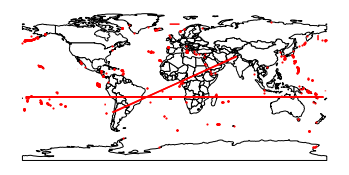

In [16]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
unassigned = specimens_gdf.loc[~specimens_gdf.index.isin([ix for frame in [specimen_to_country, specimen_to_high_seas, specimen_to_eez] for ix in frame.index.values])]

print(len(unassigned))

base = world.plot(color='white', edgecolor='black')
base.axis('off')
unassigned.plot(ax=base, marker='.', color='red', markersize=5)

### 2.5 Combined

In [17]:
geometry_location = specimen_to_country.join(specimen_to_eez, how='outer', lsuffix='_c', rsuffix='_eez')


def get_regions(row):
    row_countries = row.region_c if isinstance(row.region_c, list) else []
    row_eez = row.region_eez if isinstance(row.region_eez, list) else []
    return list(set(row_countries + row_eez))


geometry_location['region'] = geometry_location.apply(get_regions, axis=1)
geometry_location = geometry_location[['region']]
geometry_location

,region
geometry_id,
8,[Japan]
10,[Chile]
11,[Chagos Archipelago]
13,[Azores]
14,[Azores]
...,...
24093,[Northern Mariana Islands]
24095,[Northern Mariana Islands]
24097,[Northern Mariana Islands]


## 3. Citations

In [18]:
# we don't want to overload the crossref API, so cache the results
crossref_cache = os.path.join(cache, 'crossref.pkl')

# helper functions
def search_crossref(row):
    try:
        metadata = works.doi(row['doi']) if row['doi'] else {}
    except:
        print(row.doi)
        metadata = {}
    return {'citation_num': row.name, 'metadata': metadata}


def get_date(metadata):
    date_parts = metadata.get('published', metadata.get('issued', {})).get('date-parts', [[]])[
        0]
    return next((d for d in date_parts), None)



if os.path.exists(crossref_cache):
    results_df = pd.read_pickle(crossref_cache)
else:
    etiquette = Etiquette('geocolab', '0.1', 'https://github.com/geocolab', 'a.butcher@nhm.ac.uk')
    works = Works(etiquette=etiquette)

    results = []
    for i in tqdm([row for _, row in citations_df.iterrows()]):
        results.append(search_crossref(i))

    results_df = pd.DataFrame(results).set_index('citation_num')

    results_df.where(results_df.metadata != {}, inplace=True)
    results_df.dropna(inplace=True)
    results_df['doi'] = results_df.metadata.apply(lambda x: x.get('DOI'))
    results_df['title'] = results_df.metadata.apply(
        lambda x: next((t for t in x.get('title', [])), None))
    results_df['authors'] = results_df.metadata.apply(lambda x: x.get('author', []))
    results_df['container'] = results_df.metadata.apply(
        lambda x: next((t for t in x.get('container-title', [])), None))
    results_df['language'] = results_df.metadata.apply(lambda x: x.get('language'))
    results_df['year'] = results_df.metadata.apply(get_date)
    results_df.drop('metadata', inplace=True, axis=1)

    results_df.to_pickle(crossref_cache)
    
results_df

,doi,title,authors,container,language,year
4151,10.1016/j.epsl.2020.116603,Using precious metal probes to quantify mid-oc...,"[{'given': 'Hongda', 'family': 'Hao', 'sequenc...",Earth and Planetary Science Letters,en,2021.0
4177,10.1029/2020jb020237,A Mg Isotopic Perspective on the Mobility of M...,[{'ORCID': 'http://orcid.org/0000-0002-9962-81...,Journal of Geophysical Research: Solid Earth,en,2021.0
4204,10.1016/j.chemgeo.2021.120239,"Behavior of the Mo, Tl, and U isotope systems ...","[{'given': 'Richard M.', 'family': 'Gaschnig',...",Chemical Geology,en,2021.0
4175,10.1029/2020tc006516,Tectonics of the Isua Supracrustal Belt 1: P‐T...,[{'ORCID': 'http://orcid.org/0000-0001-8948-82...,Tectonics,en,2021.0
4161,10.1016/j.jafrearsci.2020.104057,Petrogenesis of basaltic and associated rhyoli...,"[{'given': 'Hagos', 'family': 'Hiluf', 'sequen...",Journal of African Earth Sciences,en,2021.0
...,...,...,...,...,...,...
195,10.1016/0025-3227(64)90019-2,The nature and composition of rock samples dre...,"[{'given': 'G.D.', 'family': 'Nicholls', 'sequ...",Marine Geology,en,1964.0
125,10.1126/science.144.3624.1330,Composition of Basalts from the Mid-Atlantic R...,"[{'given': 'A. E. J.', 'family': 'Engel', 'seq...",Science,en,1964.0
103,10.1093/petrology/5.3.409,Basalts from the Northern Part of the Rift Zon...,"[{'given': 'I. D.', 'family': 'MUIR', 'sequenc...",Journal of Petrology,en,1964.0
534,10.1126/science.140.3573.1321,Basalts Dredged from the Northeastern Pacific ...,"[{'given': 'C. G.', 'family': 'Engel', 'sequen...",Science,en,1963.0


In [19]:
citation_authors = results_df[['authors']].explode('authors').dropna()

def get_name(author):
    if not author:
        return
    family = author.get('family', '')
    given = author.get('given', '?')
    
    return ', '.join([family, given]).upper()


# a fairly crude grouping by name; name formats are not necessarily standardised, 
# so sometimes they will be given as "Person, Example" and other times as "Person, E. G.", or "PERSON, EG", etc.
citation_authors['name'] = citation_authors.authors.apply(get_name)
citation_authors

,authors,name
4151,"{'given': 'Hongda', 'family': 'Hao', 'sequence...","HAO, HONGDA"
4151,{'ORCID': 'http://orcid.org/0000-0001-8578-015...,"CAMPBELL, IAN H."
4151,{'ORCID': 'http://orcid.org/0000-0002-3432-392...,"ARCULUS, RICHARD J."
4151,"{'given': 'Michael R.', 'family': 'Perfit', 's...","PERFIT, MICHAEL R."
4177,{'ORCID': 'http://orcid.org/0000-0002-9962-817...,"DE OBESO, JUAN CARLOS"
...,...,...
103,"{'given': 'I. D.', 'family': 'MUIR', 'sequence...","MUIR, I. D."
103,"{'given': 'C. E.', 'family': 'TILLEY', 'sequen...","TILLEY, C. E."
103,"{'given': 'J. H.', 'family': 'SCOON', 'sequenc...","SCOON, J. H."
534,"{'given': 'C. G.', 'family': 'Engel', 'sequenc...","ENGEL, C. G."


In [20]:
# this will need to be cleaned up manually because it cannot reliably distinguish between countries and cities
def get_affiliation_locations(author):
    affiliation_names = [a.get('name') for a in author.get('affiliation', [])]
    locs = []
    for n in affiliation_names:
        parsed = nlp(n)
        for ent in parsed.ents:
            if ent.label_ == 'GPE':
                locs.append(ent.text.replace('.', ''))
        
    return locs

citation_authors['affiliation_locations'] = citation_authors.authors.apply(get_affiliation_locations)
citation_authors.affiliation_locations.explode().value_counts()

USA                225
China              159
France             111
Japan               88
California          68
                  ... 
Austria              1
Charleston           1
Arlington            1
Geologia Marina      1
Taipei               1
Name: affiliation_locations, Length: 292, dtype: int64

In [21]:
# again, cache API results
orcid_cache = os.path.join(cache, 'orcid.pkl')

if os.path.exists(orcid_cache):
    orcid_data = pd.read_pickle(orcid_cache)
else:
    orcid_key = 'APP-EP0TX5F74NS3PSL7' # get these from https://orcid.org/developer-tools
    orcid_secret = 'bfa765a7-a0ed-45b3-8b35-11d3f8c85ff6' #

    try:
        orcid_token
    except NameError:
        url = 'https://orcid.org/oauth/token'
        r = requests.post(url, data={
                    'client_id': orcid_key,
                    'client_secret': orcid_secret,
                    'grant_type': 'client_credentials',
                    'scope': '/read-public'
                }, headers={
                    'Accept': 'application/json'
                })
        orcid_token = r.json()['access_token']

    api = orcid.PublicAPI(orcid_key, orcid_secret, sandbox=False)


    orcid_rgx = re.compile('(?:\d{4}-){3}\d{3}[\dX]')


    def get_orcid_data(author):
        orcid_id = orcid_rgx.search(author.get('ORCID', ''))
        if not orcid_id:
            return
        record = api.read_record_public(orcid_id.group(), 'record', orcid_token)
        locs = []
        for a in record['person']['addresses']['address']:
            country = a.get('country', {}).get('value')
            try:
                country = pycountry.countries.lookup(country).name
            except:
                pass
            locs.append(country)
        for org in record['activities-summary']['employments']['employment-summary']:
            country = org.get('organization', {}).get('address', {}).get('country')
            try:
                country = pycountry.countries.lookup(country).name
            except:
                pass
            locs.append(country)
        return list(set(locs))
    
    orcid_data = citation_authors.authors.apply(get_orcid_data)
    orcid_data.to_pickle(orcid_cache)


citation_authors['orcid_locations'] = orcid_data
citation_authors.orcid_locations.explode().value_counts()

United States                125
Australia                     56
United Kingdom                44
France                        38
China                         37
Germany                       36
Canada                        21
Japan                         19
Italy                         17
Netherlands                   10
Switzerland                    8
Belgium                        7
Korea, Republic of             7
Russian Federation             7
Finland                        5
South Africa                   5
Norway                         3
Egypt                          3
Hungary                        2
Spain                          2
Portugal                       2
Hong Kong                      2
Mexico                         2
Turkey                         2
Ethiopia                       2
Singapore                      2
Israel                         2
Oman                           1
Brunei Darussalam              1
Chile                          1
India     

## 4. Results

In [22]:
results = specimens_df.explode('citations').join(citation_authors.explode('affiliation_locations').explode('orcid_locations'), on='citations').replace(np.nan, None)

def make_unique(group):
    if group.name == 'geometry_id':
        return group.values[0]
    elif group.name == 'authors':
        serialised = [json.dumps(a) for a in group.values]
        return [json.loads(a) for a in list(set(serialised))]
    else:
        return [v for v in set(group.values) if v is not None]

results = results.groupby(['specimen_num', 'citations']).agg(make_unique)
results = results.join(geometry_location, on='geometry_id')

results.to_csv('specimen_locations.csv')
results

,,geometry_id,authors,name,affiliation_locations,orcid_locations,region
specimen_num,citations,,,,,,
25947,1573,0,"[{'given': 'Stanley R.', 'family': 'Hart', 'se...","[STRACKE, ANDREAS, HART, STANLEY R., MALLICK, ...","[Woods Hole, Cambridge, Tallahassee, USA, Flor...",[],NaN
25948,1573,0,"[{'given': 'Stanley R.', 'family': 'Hart', 'se...","[STRACKE, ANDREAS, HART, STANLEY R., MALLICK, ...","[Woods Hole, Cambridge, Tallahassee, USA, Flor...",[],NaN
25949,1573,0,"[{'given': 'Stanley R.', 'family': 'Hart', 'se...","[STRACKE, ANDREAS, HART, STANLEY R., MALLICK, ...","[Woods Hole, Cambridge, Tallahassee, USA, Flor...",[],NaN
25950,1573,0,"[{'given': 'Stanley R.', 'family': 'Hart', 'se...","[STRACKE, ANDREAS, HART, STANLEY R., MALLICK, ...","[Woods Hole, Cambridge, Tallahassee, USA, Flor...",[],NaN
25951,197,1,"[{'given': 'R.K.', 'family': 'O'Nions', 'seque...","[EVENSEN, N.M., O'NIONS, R.K., HAMILTON, P.J.]",[USA],[],NaN
...,...,...,...,...,...,...,...
821732,3826,24116,"[{'given': 'Daniel S.', 'family': 'Barker', 's...","[NIXON, PETER H., BARKER, DANIEL S.]",[UK],[Australia],[Uganda]
821733,3826,24116,"[{'given': 'Daniel S.', 'family': 'Barker', 's...","[NIXON, PETER H., BARKER, DANIEL S.]",[UK],[Australia],[Uganda]
821734,3826,24116,"[{'given': 'Daniel S.', 'family': 'Barker', 's...","[NIXON, PETER H., BARKER, DANIEL S.]",[UK],[Australia],[Uganda]
